In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno
import warnings

import math
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')
# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("students_df_cleaned.csv")


In [7]:
df.head()


,Unnamed: 0,tottr,hhmem,mode_category,duration_min,trip_distance_miles,city_from_zip,gender,age,citizen,...,precip_hours (h),model_year,body_type,fuel_type1,purchase_type,ownership,transmission,cylinders,veh_type,departure_datetime
0,0,3.0,1.0,Auto Passenger,20.0,3.619057,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-05-12 11:10:00
1,1,3.0,1.0,Auto Passenger,14.0,2.545849,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-05-12 11:31:00
2,2,3.0,1.0,Auto Passenger,8.0,1.961798,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-05-12 11:52:00
3,3,5.0,4.0,Auto Passenger,20.0,3.587950,Greater Los Angeles Area,1.0,15.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-05-12 15:30:00
4,4,3.0,2.0,Auto Passenger,20.0,3.619057,Greater Los Angeles Area,1.0,14.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-05-12 08:15:00


In [8]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns.tolist()

# Print the non-numeric columns
print("Non-numeric columns:")
print(non_numeric_columns)

Non-numeric columns:
['mode_category', 'city_from_zip', 'departure_datetime']


In [33]:
# check for numeric values 
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

print("Numeric columns:")
print(numeric_columns)

Numeric columns:
['Unnamed: 0', 'tottr', 'hhmem', 'duration_min', 'trip_distance_miles', 'gender', 'age', 'citizen', 'driver_license', 'transit_pass', 'car_sharing', 'disabled', 'transit_trip', 'transit_subsidy', 'walk_trips', 'bike_trips', 'student', 'school_grade', 'education', 'person_trips', 'race', 'incentive', 'vehicle_count', 'bike_count', 'residence_type', 'home_own', 'income', 'persons_count', 'worker_count', 'student_count', 'license_count', 'trip_count', 'WMO_code', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)', 'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'daylight_dur (s)', 'total_ precip (mm)', 'rain (mm)', 'snowfall (cm)', 'precip_hours (h)', 'model_year', 'body_type', 'fuel_type1', 'purchase_type', 'ownership', 'transmission', 'cylinders', 'veh_type']


In [10]:
print(pd.to_datetime(df['departure_datetime']))

0       2012-05-12 11:10:00
1       2012-05-12 11:31:00
2       2012-05-12 11:52:00
3       2012-05-12 15:30:00
4       2012-05-12 08:15:00
                ...        
40813   2013-01-22 18:13:00
40814   2013-01-30 07:24:00
40815   2013-01-30 12:55:00
40816   2013-01-30 13:26:00
40817   2013-01-21 15:20:00
Name: departure_datetime, Length: 40818, dtype: datetime64[ns]


In [ ]:
df['hov_lane']

KeyError: 'motor_trip'

In [ ]:
def selected_feature(data):
    
    # Temporal Features from time 
    # we arent using Unix time since I think that causes too much overfitting and the test data starts in 2010
    # accounts for daily peaks etxx.
    data['Hour'] = pd.to_datetime(data['departure_datetime']).dt.hour
    # accounts for the fluxuations between start/end of month behavior
    data['Day_of_Month'] = pd.to_datetime(data['departure_datetime']).dt.day
    # accounts for the shifts in ridership between months
    data['Month'] = pd.to_datetime(data['departure_datetime']).dt.month
    # accounts for changes / growth or decrease over years 
    data['Year'] = pd.to_datetime(data['departure_datetime']).dt.year
    # accounts for weekend/weekday fluxuations
    data['Weekday'] = pd.to_datetime(data['departure_datetime']).dt.weekday   # 0-6 (Mon-Sun)
    # since its very seasonal lets put in the seaons! 
    # Define the seasons based on the month
    seasons = {
        1: 1, 2: 1, 12: 1, # winter (1)
        3: 2, 4: 2, 5: 2, # spring (2)
        6: 3, 7: 3, 8: 3, #summer (3)
        9: 4, 10: 4, 11: 4 #fall (4)
    }

    # Apply the season logic to the month column 
    data['Season'] = data['Month'].map(seasons)




    feature_selected = [#'tottr',
                        'gender',
                        'race',
                        'age',
                        # 'incentive', # does not exist 
                        # 'vehicle_count', 'bike_count', # psossible overfit here so added friends
                        'residence_type', # this is scuffed varible might need alt encoding     
                        'school_grade', 
                        'income',
                        'citizen', # international studentents idk 
                        'driver_license',
                        'apparent_temperature_mean (°C)',
                        'WMO_code',
                        'Hour',
                        'Day_of_Month',
                        'Month',
                        'Weekday',
                        'Season',
                        'motor_trip'
                        # alterantives to add (1)
                        # 'persons_count', 'worker_count', 'student_count', - for family distibution etxx 
                        # 'education', 'person_trips', - edu overfit with school grade (kinda0)
                        # 'transit_trip', 'walk_trips', 'bike_trips' # attached histoical data fro these individuals 
                        ]

    selected_data = data[feature_selected]
    
    return selected_data

In [25]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into data (70%) and temp (30%)
data_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the dataing set
X_data = selected_feature(data_df)
y_data = data_df['mode_category']

# Step 4: Apply SMOTE to the dataing set
smote = SMOTE(random_state=42)
X_data_resampled, y_data_resampled = smote.fit_resample(X_data, y_data)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_data))
print("Class distribution after SMOTE:", Counter(y_data_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"dataing set size: {X_data_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Passenger': 19016, 'Active Transportation': 5060, 'Auto Driver': 2890, 'Transit': 1525, 'Other': 81})
Class distribution after SMOTE: Counter({'Auto Passenger': 19016, 'Active Transportation': 19016, 'Auto Driver': 19016, 'Transit': 19016, 'Other': 19016})
dataing set size: 95080
Validation set size: 6123
Test set size: 6123


In [26]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_data_resampled, y_data_resampled)

RandomForestClassifier(random_state=42)

In [27]:
y_pred = model.predict(X_val)

#### Check the performance of the model

In [28]:
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy of the Random Forest Classifier: {accuracy * 100:.2f}%")

Accuracy of the Random Forest Classifier: 80.79%


In [29]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(model, X_data_resampled, y_data_resampled, cv=5)

print(f"Cross-Validated Accuracy: {cv_scores.mean() * 100:.2f}%")

Cross-Validated Accuracy: 91.82%


In [30]:
from sklearn.metrics import classification_report, f1_score

# Step 1: Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Step 2: Generate classification report
report = classification_report(y_val, y_pred, target_names=['Auto Passenger', 'Active Transportation', 'Transit','Auto Driver', 'Other'], digits=3)
print("\nClassification Report:\n", report)

# Step 3: Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': 1084, 'Auto Driver': 619, 'Auto Passenger': 4075, 'Other': 18, 'Transit': 327}

Classification Report:
                        precision    recall  f1-score   support

       Auto Passenger      0.582     0.536     0.558      1084
Active Transportation      0.852     0.913     0.881       619
              Transit      0.896     0.913     0.905      4075
          Auto Driver      0.267     0.222     0.242        18
                Other      0.256     0.229     0.242       327

             accuracy                          0.808      6123
            macro avg      0.571     0.563     0.566      6123
         weighted avg      0.800     0.808     0.804      6123


Weighted F1-Score: 0.803610917637856



Top 10 Important Features:
                           Feature  Importance
7                   driver_license    0.131599
2                              age    0.123398
8   apparent_temperature_mean (°C)    0.095935
10                            Hour    0.085908
11                    Day_of_Month    0.082346
5                           income    0.076736
4                     school_grade    0.074679
9                         WMO_code    0.070389
13                         Weekday    0.053594
12                           Month    0.052240


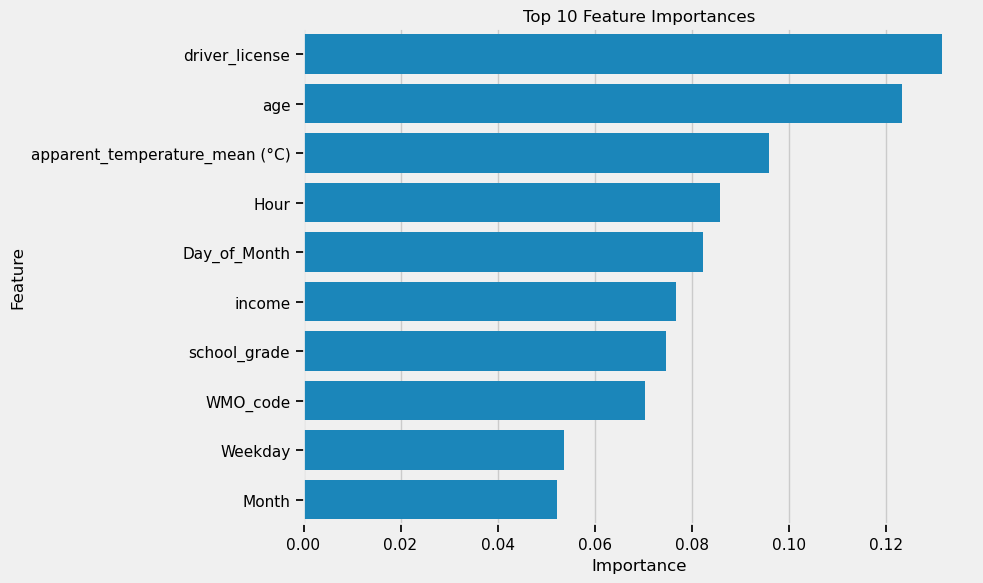

In [31]:
# Feature importances
importances = model.feature_importances_
feature_names = X_data.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()